In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fixed_point
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import estimation_functions
# from integrated_market_model.market import IntegratedMarketModel

In [2]:
import sys
sys.path.append('../')
from integrated_market_model.market import IntegratedMarketModel
# import sys
 
# adding Folder_2 to the system path
# sys.path.insert(0, '../integrated_market_model')


In [3]:
df = pd.read_csv(f'../data/market_integrates_1.csv')
print(df)


     market_ids  firm_ids  characteristic1  characteristic2    prices  \
0             1         1         5.348061        20.964655  3.263354   
1             1         2         5.134796        20.155075  4.093757   
2             1         3         5.170203        20.191143  4.084675   
3             1         4         5.551272        20.831672  3.431042   
4             1         5         5.830341        20.934608  2.991747   
..          ...       ...              ...              ...       ...   
995         100         6         5.977387        20.225459  3.347218   
996         100         7         5.083662        20.315749  3.435301   
997         100         8         5.254944        20.117505  3.581924   
998         100         9         5.849048        20.945524  2.807978   
999         100        10         5.302210        20.055657  3.206264   

     marginal_cost    shares   profits   markups  e_quantity    capital  \
0         0.870393  0.023810  0.056976  3.749289

In [4]:
# Generate market model at wrong theta 
theta_0 = [1., 1., 1., 1., 1.]
# theta_0 = [2., -0.5, -0.3, 0.5, 1.]

# Frist stage regression some work 

x = df[['marginal_cost', 'characteristic1', 'characteristic2']]

res = LinearRegression().fit(x, df['prices'])

print('Intercept: \n', res.intercept_)
print('Coefficients: \n', res.coef_)

predictions_price = res.predict(x)
df['predict_prices'] = predictions_price



Intercept: 
 3.355633734351109
Coefficients: 
 [ 1.46691632 -0.04969762 -0.06726274]


In [5]:
def objective_minimization(theta, n_firms, n_consumers, n_chars, T, s, df, v_p_all):
    estimation_model = IntegratedMarketModel(
            n_firms, 
            n_consumers, 
            n_chars, 
            T,
            beta=np.array(theta[:3]),
            mu=theta[3],
            omega=theta[4],
            seed=s
        )
    
    e=0
    all_estimated_shares = np.zeros(n_firms*T)
    all_indirect_utilities = np.zeros(n_firms*T)
    for t in range(0, T):
        v_p = v_p_all[:,t]
        # price_period = np.array(df.predict_prices[t*n_firms:(t+1)*n_firms])
        price_period = np.array(df.prices[t*n_firms:(t+1)*n_firms])
        estimated_shares, estimated_probabil, indirect_util = estimation_model.compute_share(v_p, price_period, e)
        all_estimated_shares[t*n_firms:(t+1)*n_firms] = estimated_shares
        all_indirect_utilities[t*n_firms:(t+1)*n_firms] = indirect_util

    # return all_indirect_utilities + np.log(df.shares) - np.log(all_estimated_shares)
    return mean_squared_error(df.shares, all_estimated_shares)


In [6]:
n_firms = 10
n_consumers = 500
n_chars = 2
T = 100
s = 1
v_p_all = np.random.normal(0, 1, (n_consumers, T))

res = minimize(objective_minimization, theta_0, args=(n_firms, n_consumers, n_chars, T, s, df, v_p_all), method = 'Nelder-Mead')
    # optim_vec = res.x
print(res)


       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 2.838670360142151e-06
             x: [ 8.031e-01 -4.419e-01 -3.216e-01 -7.344e-01  5.863e-01]
           nit: 615
          nfev: 1000
 final_simplex: (array([[ 8.031e-01, -4.419e-01, ..., -7.344e-01,
                         5.863e-01],
                       [ 8.043e-01, -4.411e-01, ..., -7.358e-01,
                         5.864e-01],
                       ...,
                       [ 8.030e-01, -4.419e-01, ..., -7.341e-01,
                         5.869e-01],
                       [ 8.027e-01, -4.416e-01, ..., -7.328e-01,
                         5.875e-01]]), array([ 2.839e-06,  2.839e-06,  2.839e-06,  2.839e-06,
                        2.839e-06,  2.839e-06]))


In [7]:

df2 = df.groupby('market_ids').sum('shares')
outside_good = np.repeat(np.array(df2.shares), n_firms)

# Get outside good same shape datagrame repeat each 10 times 
y = np.log(np.array(df.shares)) - np.log(outside_good)
print(y)


[-2.26661241 -2.23620335 -2.26150152 -2.39707343 -2.38193157 -2.46353064
 -2.26709096 -2.16938739 -2.46295389 -2.17378288 -2.3307608  -2.25583323
 -2.19822069 -2.3928708  -2.34091753 -2.53685949 -2.29065619 -2.18509894
 -2.46827031 -2.10477694 -2.39180011 -2.3180747  -2.20535589 -2.3083236
 -2.36975425 -2.55480869 -2.24957691 -2.14395703 -2.48872576 -2.0909269
 -2.32190328 -2.26289308 -2.26939052 -2.3112726  -2.25818305 -2.53955949
 -2.29514273 -2.25808615 -2.47698717 -2.09867036 -2.32699271 -2.21862493
 -2.22236037 -2.2571027  -2.3157617  -2.51963308 -2.2683158  -2.3437086
 -2.48803272 -2.129173   -2.36893186 -2.24846672 -2.2360106  -2.25177339
 -2.33822557 -2.48284432 -2.20694143 -2.42608181 -2.41953486 -2.1088649
 -2.36721127 -2.21437871 -2.22864276 -2.22335233 -2.43058319 -2.48216598
 -2.18164754 -2.38902322 -2.43049229 -2.14557233 -2.35825409 -2.27692419
 -2.28092062 -2.20495812 -2.44813756 -2.42454564 -2.15292329 -2.41618314
 -2.45357244 -2.08742684 -2.41938439 -2.2699245  -2.190

In [8]:
# Easy ols estimation 

# x = df[['prices', 'characteristic1', 'characteristic2']]

# res = LinearRegression().fit(x, y)

# print('Intercept: \n', res.intercept_)
# print('Coefficients: \n', res.coef_)



In [9]:
# Second stage: 

# x = df[['predict_prices', 'characteristic1', 'characteristic2']]

# res = LinearRegression().fit(x, y)

# print('Intercept: \n', res.intercept_)
# print('Coefficients: \n', res.coef_)



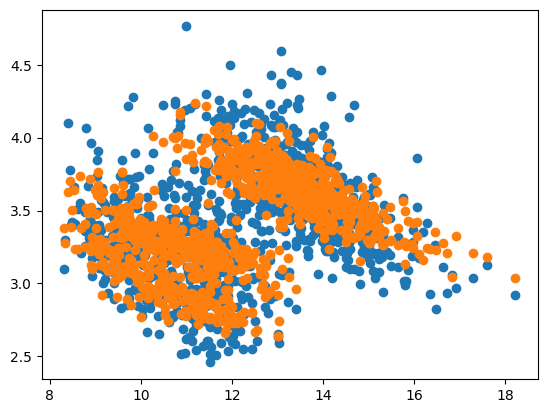

In [10]:

plt.scatter(df.e_quantity, df.prices)
plt.scatter(df.e_quantity, df.predict_prices)
plt.show()

In [11]:
# N = 500
# firms  = 5
# time = 100 

# all_val_b0 = []
# all_val_b1 = []
# all_val_b2 = []
# all_val_mu = []
# all_val_omega = []
# mean_share = []

# for l in range(1, 5):
    
#     res = minimize(f, theta_0, args=(df, N, firms, time), method = 'Nelder-Mead')
#     optim_vec = res.x

#     all_val_b0.append(optim_vec[0])
#     all_val_b1.append(optim_vec[1])
#     all_val_b2.append(optim_vec[2])
#     all_val_mu.append(optim_vec[3])
#     all_val_omega.append(optim_vec[4])

#     # new_shares = estimation_functions.shares_optimal(optim_vec, df, v_p, N, firms, time)


# df_estimation_values = pd.DataFrame({'beta_0': all_val_b0,
#                                     'beta_1': all_val_b1,
#                                     'beta_2': all_val_b2, 
#                                     'mu': all_val_mu, 
#                                     'omega': all_val_omega, 
#                                     })
# df_estimation_values.to_csv(f'../data/first_estimation_market_inter_100', index=False)


In [12]:
# print(df_estimation_values)
# df_estimation_values.to_csv(f'../data/estimation_thetaones.csv', index=False)

In [13]:
# fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3, 2)
# fig.suptitle(f'Estimation results frist run')

# ax1.hist(df_estimation_values.beta_0, bins=50, color='red')
# ax2.hist(df_estimation_values.beta_1, bins=50, color='orange')
# ax3.hist(df_estimation_values.beta_2, bins=50, color='green')
# ax4.hist(df_estimation_values.mu, bins=50, color='lightblue')
# ax5.hist(df_estimation_values.omega, bins=50, color='pink')
# ax6.hist(df.shares, bins=50)


# ax1.set_title('beta0')
# ax2.set_title('beta1')
# ax3.set_title('beta2')
# ax4.set_title('mu')
# ax5.set_title('omega')
# ax6.set_title('shares')

# plt.tight_layout()
# plt.show()
